In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
#following code fetches the MNIST dataset from OpenML.org

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame=False)

C:\Users\ews\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist.data, mnist.target

In [5]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
X.shape

(70000, 784)

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [8]:
y.shape

(70000,)

In [9]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

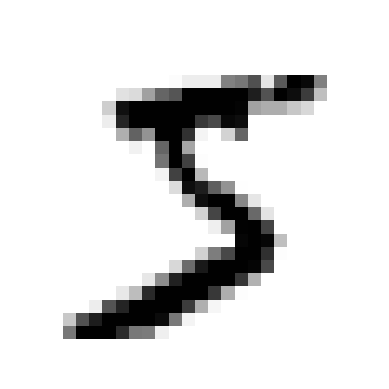

In [10]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [11]:
y[0]

'5'

In [12]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [13]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

# Training a Binary Classifier

Let's try to identify one digit (number 5). This "5-detector" is an example of a binary classifier, it will predict, for any row, 5 or not-5.


Let's create the target vector for the classification task:

Let's take a fraction of the training data for the notebook to run fast locally

In [14]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Lets start with a Stochastic Gradient Descent Classifier:

In [15]:
from sklearn.linear_model import SGDClassifier

In [16]:
sgd_clf = SGDClassifier(random_state=42)

In [17]:
sgd_clf.fit(X=X_train, y=y_train_5)

SGDClassifier(random_state=42)

In [18]:
sgd_clf.predict(X=[some_digit])

array([ True])

In [19]:
from sklearn.model_selection import cross_val_score

In [20]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [21]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [22]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [23]:
from sklearn.model_selection import cross_val_predict

In [24]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
cm = confusion_matrix(y_train_5, y_train_pred)

In [27]:
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [28]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection

In [29]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [30]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [31]:
from sklearn.metrics import precision_score, recall_score

In [32]:
precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [33]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

In [34]:
from sklearn.metrics import f1_score

In [35]:
 f1_score(y_train_5, y_train_pred)

0.7325171197343846

# Precision-Recall Trade-off

To understand this trade-off, we need to know how the algorithm is making its decisions.

For each instance, the classifier outputs a score (we can call it a probability), if the score is higher than a certain threshold, we label the instance as positive (a "5"), but if the score is less than the threshold, we the instance as negative (a "not 5")


As we can see, if we raise the threshold, precision converges to 
, but as a result, we lower the recall. Same happens to recall if we lower the threshold, we get a better recall (False Negatives are fewer) but we decrease precision.

Scikit-learn doesn't allow us to set the threshold directly, but it can give us the scores for each of its prediction.

We can set the threshold we want after getting the scores:

In [36]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [37]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [38]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How do we decide which threshold to use?

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [40]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

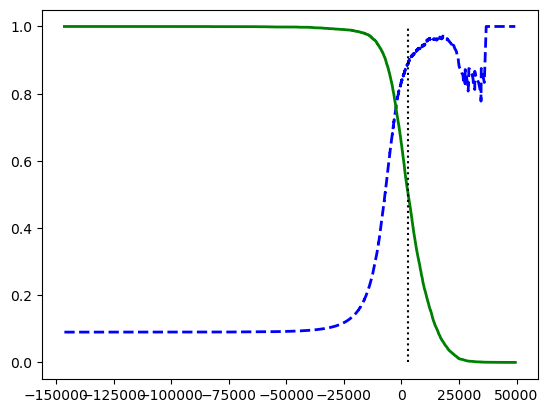

In [41]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
[...] # beautify the figure: add grid, legend, axis, labels, and circles
plt.show()

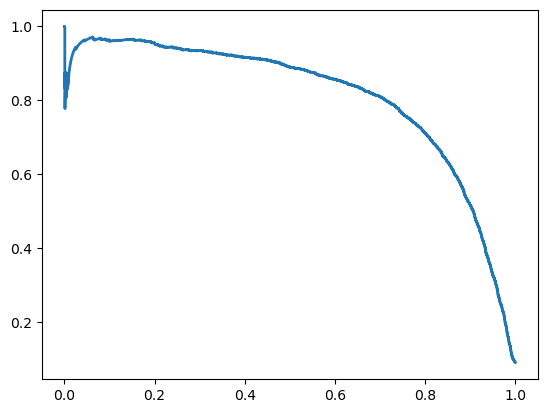

In [42]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
[...] # beautify the figure: add labels, grid, legend, arrow, and text
plt.show()

In [43]:
 idx_for_90_precision = (precisions >= 0.90).argmax()

In [44]:
 threshold_for_90_precision = thresholds[idx_for_90_precision]

In [45]:
 threshold_for_90_precision

3370.0194991439557

In [46]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [47]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [48]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)

In [49]:
recall_at_90_precision

0.4799852425751706

# The ROC Curve

ROC plots TP rate versus FP rate.

ROC plots recall versus 1 - specificity

In [50]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

To find the point that corresponds to
90% precision, we need to look for the index of the desired threshold. Since
thresholds are listed in decreasing order in this case, we use <= instead of >=
on the first line

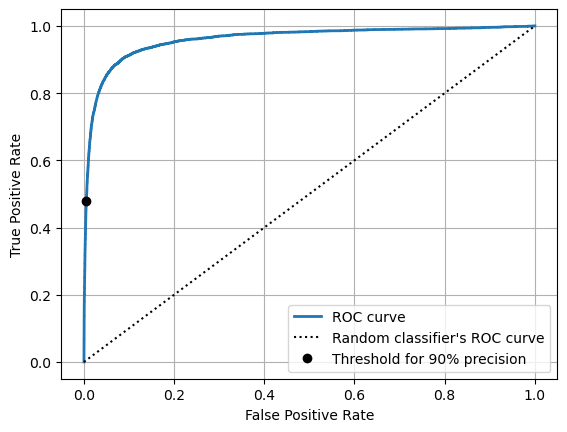

In [51]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.legend(loc="lower right")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

The Higher the recall, the more false positives the model produces.

The dotted line represent the ROC curve of a completely random classifier. A good classifier stays as far a way as possible from the dotted line.

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have an ROC AUC of 1 and a purely random classifier will have an ROC AUC of 0.5

In [52]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let's now train a RandomForestClassifier to compare its ROC Curve and ROC AUC score to the SGDClassifier's:

In [53]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [54]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

In [55]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and
it predicts that the second image is negative with 99% probability. Since
each image is either positive or negative, the probabilities in each row add
up to 100%.


The second column contains the estimated probabilities for the positive
class, so let’s pass them to the precision_recall_curve() function

In [56]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

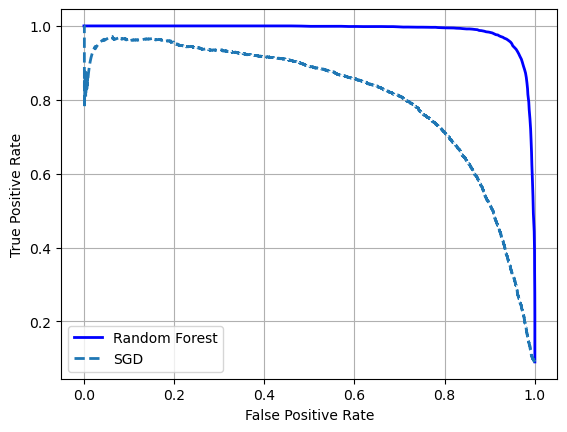

In [57]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.grid()
plt.legend(loc="lower left")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [58]:
y_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba ≥ 50%
f1_score(y_train_5, y_pred_forest)

0.9274509803921569

In [59]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [60]:
precision_score(y_train_5, y_pred_forest)

0.9897468089558485

In [61]:
recall_score(y_train_5,y_pred_forest)

0.8725327430363402

train classifiers

choose the appropriate metric for the task

evaluate the classifier using cross-validation

select the precision-recall ratio that fits the needs

use ROC and ROC AUC to compare various models

In [62]:
# Multiclass Classification

There are techniques we can use to perform multiclass classification with binary classifiers. One way to create a system that can classify an image into 10 labels (from 0 to 9) is to train 10 binary classifiers (one for each digit).

Then when we want to classify an image, we get each classifier's associated positive score and pick the model class w/ the highest score. This is called one-versus-the-rest startegy(OvR), or 1-vs-all(OvA).

Another startegy is to train a binary classifier for each pair of digits. This is called 1-vs-1(OvO). If there are N classes, we would need to train N*(N-1)/2 classifiers.
 
. For the MNIST Problem, this means training 45 binary classifiers. The class which wins the most duals is the predicted one.

The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish.

Some algorithms (such as support vector machine classifiers) scale poorly
with the size of the training set. For these algorithms OvO is preferred
because it is faster to train many classifiers on small training sets than to
train few classifiers on large training sets

Scikit-learn detects when we try to use a binary classification algorithm for a multiclass classification problem, it then automatically use OvO or OvR depending on the algorithm to train.

In [63]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

SVC(random_state=42)

In [64]:
 svm_clf.predict([some_digit])

array(['5'], dtype=object)

This code actually made 45 predictions—one per pair of
classes—and it selected the class that won the most duels. If you call the
decision_function() method, you will see that it returns 10 scores per
instance: one per class

In [65]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [66]:
class_id = some_digit_scores.argmax()
class_id

5

When a classifier is trained, it stores the list of target classes in its classes_
attribute, ordered by value. In the case of MNIST, the index of each class in
the classes_ array conveniently matches the class itself (e.g., the class at
index 5 happens to be class '5')

In [67]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [68]:
 svm_clf.classes_[class_id]

'5'

If you want to force Scikit-Learn to use one-versus-one or one-versus-therest, you can use the OneVsOneClassifier or OneVsRestClassifier
classes. Simply create an instance and pass a classifier to its constructor

In [69]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

Let’s make a prediction, and check the number of trained classifiers

In [70]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [71]:
len(ovr_clf.estimators_)

10

Training an SGDClassifier on a multiclass dataset and using it to make
predictions

In [72]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

The decision_function() method now returns one
value per class. Let’s look at the scores that the SGD classifier assigned to
each class

In [73]:
 sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

You can see that the classifier is not very confident about its prediction:
almost all scores are very negative, while class 3 has a score of +1,824, and
class 5 is not too far behind at –1,386. Of course, you’ll want to evaluate this
classifier on more than one image.

As usual, you can use the
cross_val_score() function to evaluate the model:

In [74]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

A colored diagram of the confusion matrix is much easier to analyze. To plot
such a diagram, use the ConfusionMatrixDisplay.from_predictions()
function like this

In [76]:
from sklearn.metrics import                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ConfusionMatrixDisplay

In [77]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

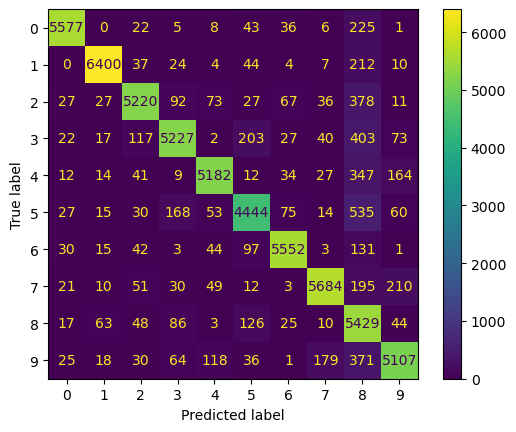

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

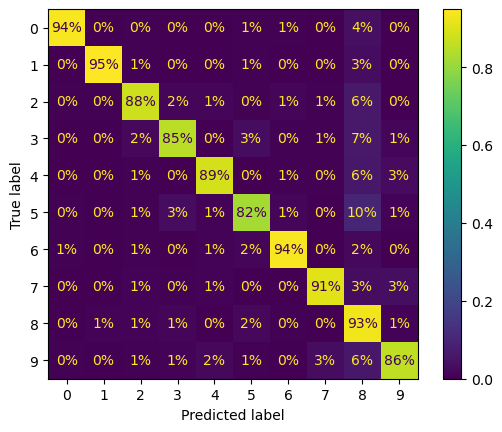

In [80]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
normalize="true", values_format=".0%")
plt.show()

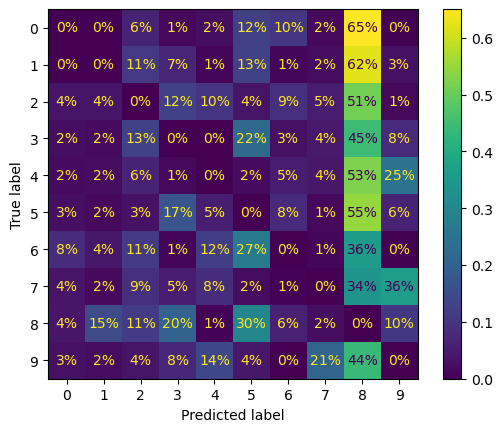

In [81]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
sample_weight=sample_weight,
normalize="true", values_format=".0%")
plt.show()

We can clearly see the kind of errors the classifier makes. Remember that the rows represent acutal labels and the columns represent the predicted class.

The column of class 8 is quite bright, which tells us that many input images get misclassified as 8s. However, the row for 8s is not that bad, telling us that when given input images of 8s, the model does a good job of classifying them as 8s.

As we can see, the confusion matrix is not necessarly symmetrical. In our specific example, 3s and 5s are often confused.

Analyzing the confusion matrix often gives us insights into how to improve the classifier itself.

Looking at this plot, it seems that our efforts should be focused on reducing the false 8s. For example, we could try collecting images of digits that look like 8s but are not, then training the classifier to better distinguish.

Analyzing our errors could be also a good way into knowing what the model is learning and why is it failling.

In [82]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

[Ellipsis]

In [96]:
from math import ceil

In [97]:
def plot_digits(instances, images_per_row=10, **options):
    """Plots digits on a grid of rows and columns
    
    # Arguments
        instances: np.ndarray, the digits, where each is a flat array
        images_per_row: int, how many digits to be displayed per row
        options: other arguments for `plt.imshow()`
    """
    size = 28
    n_images = instances.shape[0]
    images_per_row = min(images_per_row, n_images)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = ceil(n_images / images_per_row)
    row_images = list()
    n_empty = (n_rows * images_per_row) - n_images
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row*images_per_row : (row+1)*images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap='binary', **options)
    plt.axis('off')

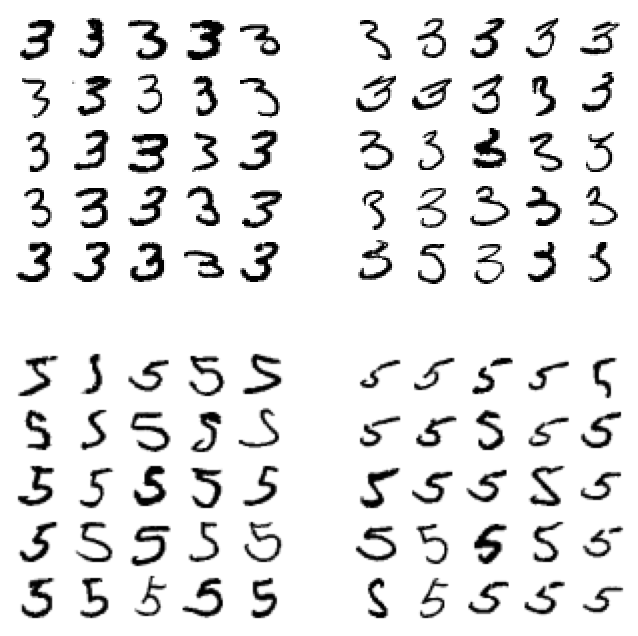

In [98]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5x5 blocks on the left show instances classified as 3s, and the two 5x5 blocks on the right show instances classified as 5s.

Most misclassifed images seem like obvious mistakes to us and it's hard for us to understand why the classifier made the mistakes it did.

The true reason is that when we used SGDClassifier, which is a linear model, it just assigns weights to each pixel, and when it gets a new image, it sums up the pixel intensities times the trained weights, and since 5s and 3s share most of the pixel intensity locations, the model get sometimes confused.

The main difference between a 5 and a 3 is the position of the small line that joins the top line to the bottom arc.

Meaning that if we draw a 3 with a slightly shifted line to the left, the classifier might assign it a 5, and same to 5s classified as 3s.

In other words, this classifier is quite sensitive to image rotation and shifting. So one way to reduce errors is to preprocess the images to make sure the digits are well centered and not too rotated.

In some cases, we want our classifier to output multiple classes per instance (e.g. Face recognition in images).

What should it do when it recognizes several people in a picture?

Such system that outputs multiple binary scores that don't necessarly sum up to 1 is called a multilabel classifier.

Let's go through a simple example:

In [83]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [84]:
 knn_clf.predict([some_digit])

array([[False,  True]])

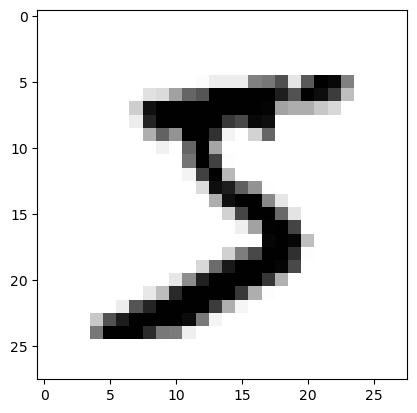

In [99]:
plt.imshow(some_digit.reshape(28, 28), cmap='binary')

Got it right! 5 is indeed less than 7 and odd.

There are many ways to evaluate a multilabel classifier, selecting the best metrics will depend on the project. One approach is to simply calculate 
 score for each label category, then average all scores into one number:

In [85]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [86]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all label categories are equally important, which may not be true. In particular, if we have more pictures of alice than bob we may want to give more weight to bob pics in evaluation. This is called unbalanced classes within a label category.

One simple way to do it is to give each class a score corresponding to it support. The less samples we have of bob, the more important one score of him is.

In [87]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [88]:
chain_clf.predict([some_digit])

array([[0., 1.]])

Multioutput Classification

The last type of classification we will discuss is called multioutput-multiclass classification (Ex. Identifying animals in a picture & for each animal we have N classes). Meaning, each label can be multiclass.

To demonstrate this, let's build a system that removes noise from images. It will take the noisy digit images as input, and will hopefully output an image that look like the original one from the dataset. Notice that the system is a multioutput classification one (Output: 728 pixels, each pixel intensity ranges from 0 to 255).

Let's start with training data by adding a mask of noise, the original image will serve as the output (target):

In [100]:
noise = np.random.randint(low=0, high=100, size=(X_train.shape[0], 784))

In [101]:
X_train_mod = X_train + noise
X_train_mod.shape

(60000, 784)

In [102]:
noise = np.random.randint(low=0, high=100, size=(X_test.shape[0], 784))

In [103]:
X_test_mod = X_test + noise
X_test_mod.shape

(10000, 784)

In [104]:
y_train_mod = X_train.copy()
y_test_mod = X_test.copy()

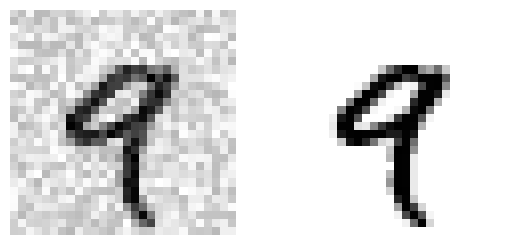

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(X_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[0].axis('off')
ax[1].imshow(y_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[1].axis('off')
plt.show()

In [106]:
knn_clf.fit(X=X_train_mod, y=y_train_mod)

KNeighborsClassifier()

In [107]:
clean_digit = knn_clf.predict(X=[X_test_mod[234]]).reshape(28, 28)

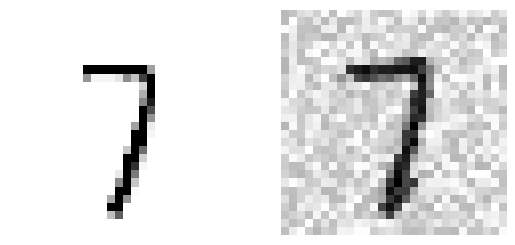

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(clean_digit, cmap='binary'); ax[0].axis('off')
ax[1].imshow(X_test_mod[234].reshape(28, 28), cmap='binary'); ax[1].axis('off')
plt.show()